In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tud
import torch.optim as optim

torch.cuda.is_available(), torch.cuda.device_count()

(True, 1)

#### freeze随机种子，这样后面跑模型每次都是一样的，能看出性能

In [2]:
import random
import numpy as np
from tqdm import tqdm

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed(1)

#### 构造BOW

In [3]:
with open('./dataset/corpus_havestp_C.txt', 'r', encoding='utf8') as f:
    text = [s.strip() for s in f.readlines()[:10]] #to drop '\n' 

s_to_wordlist = [s.split() for s in text] #one sentence -> one words_list
print('number of sentences:',len(s_to_wordlist))

word_list = list(set(' '.join(text).split()))
print('number of words:', len(word_list)) 
word_to_idx = {w:i for i,w in enumerate(word_list)}

number of sentences: 10
number of words: 2502


#### 构造skip_gram dataset
<img src="./dataset/skip_gram.png" width="500" align="left"/>

In [4]:
window_size = 2
SG_data = []
for s in s_to_wordlist:
    L = len(s)
    for i in range(0, L): #每个i都作一个center word
        center_idx = word_to_idx[s[i]]
        
        left = max(0, i-window_size) 
        right = min(L, i+window_size)
#         print(left, right, s)
        if left >= right:
            continue
        context_idx = [word_to_idx[s[j]] for j in range(left, right) if j!=i]
        for w in context_idx:
            SG_data.append([center_idx, w])
            
for i in SG_data[:10]:
    print(word_list[i[0]], word_list[i[1]], )
SG_data = torch.Tensor(SG_data).type(torch.LongTensor)
SG_data.shape

问责 领导
领导 问责
领导 上
上 问责
上 领导
上 黄镇
黄镇 领导
黄镇 上
黄镇 党委书记
党委书记 上


torch.Size([19565, 2])

In [5]:
batch_size = 30
embed_size = 20  # To show 2 dim embedding graph
vocab_size = len(word_list)

def random_batch(data, batch_size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), batch_size, replace=False)
    for i in random_index: #随机选batch_size个样本
        random_inputs.append(np.eye(vocab_size)[data[i][0]])  # center word的onehot
        random_labels.append(data[i][1])  # context word
    
#     print(random_inputs[1].shape, random_labels)
    return random_inputs, random_labels

In [47]:
class SG_onehot(nn.Module):
    def __init__(self):
        super(SG_onehot, self).__init__()
        initrange = 1#0.5 / embed_size
        self.linear1 = nn.Linear(vocab_size, embed_size)
        self.linear1.weight.data.uniform_(-initrange, initrange)
        self.linear2 = nn.Linear(embed_size, vocab_size)
        self.linear2.weight.data.uniform_(-initrange, initrange)

    def forward(self, X):#batch_size, vocab_size
        hidden_layer = self.linear1(X) # batch_size, embed_size
        y_pred_prob = self.linear2(hidden_layer) # batch_size, vocab_size
        return y_pred_prob 

    
model = SG_onehot().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in tqdm(range(1000)):
    input_batch, target_batch = random_batch(SG_data, batch_size)
    input_batch = torch.Tensor(input_batch).cuda()
    target_batch = torch.LongTensor(target_batch).cuda()
    
    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, vocab_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if epoch%100 == 0:
        print('Epoch:', epoch, ',Loss=%.6f'%loss)

    loss.backward()
    optimizer.step()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


TypeError: new() received an invalid combination of arguments - got (list, type=torch.tensortype), but expected one of:
 * (torch.device device)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, torch.device device)
      didn't match because some of the keywords were incorrect: type
 * (object data, torch.device device)
      didn't match because some of the keywords were incorrect: type


In [ ]:
model.parameters()

In [30]:
embedding_weights = model.linear1.weight.cpu().detach().numpy().T
embedding_weights.shape

(2502, 20)

(50, 20) (50, 2)


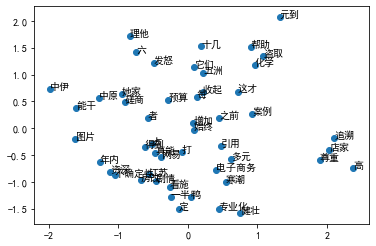

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
words = word_list[:50]
X = embedding_weights[:50]
X_2 = PCA(n_components=2).fit_transform(X)
print(X.shape, X_2.shape)

plt.scatter(X_2[:, 0], X_2[:, 1])  # 散点图的xy坐标
for i, word in enumerate(words):
    plt.annotate(word, xy=(X_2[i, 0], X_2[i, 1]))
plt.show()